In [13]:
# general
import datetime

# nn related
import torch
import torch as th
import torch.nn as nn
import numpy as np
from numpy import linalg as la

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib as mpl
from matplotlib.transforms import Bbox

import sys, re, os, path
from matplotlib import axis
import seaborn as sns
colors=sns.color_palette()

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')
from scripts.preProcess import readPatchData
from scripts.preProcess import readCellCenters
from scripts.preProcess import readVectorData
from scripts.utilities import *

from scripts import preProcess as pre

In [14]:
def mse_b_unique(a, b):
    return nn.MSELoss()(a[:, [0, 1, 2, 4, 5, 8]], b[:, [0, 1, 2, 4, 5, 8]])

In [15]:
# rans data
rans_path = '/home/leonriccius/Documents/Fluid_Data/rans_kaandorp/ConvDivChannel/Re7900_kOmega_100'
rans_time = max([int(entry) for entry in os.listdir(rans_path) if entry.isnumeric()])
print(rans_time)

# dns data
path_dns = '/home/leonriccius/Documents/Fluid_Data/tensordata_unscaled_inv_corr/ConvDivChannel/7900'
b_dns = th.load(os.sep.join([path_dns, 'b_dns-torch.th']))

7000


In [16]:
# define model paths
model_base = '/home/leonriccius/PycharmProjects/data_driven_rans/storage/models/kaandorp_data/weight_decay/cdc7900'
builtin_path = os.sep.join([model_base, 'builtin'])
sep_path = os.sep.join([model_base, 'sep'])

# read in parameters
folders = sorted([folder for folder in os.listdir(builtin_path) if os.path.isdir(os.sep.join([builtin_path, folder]))], reverse=False)
lambdas = np.array(folders, dtype=float)
print(folders)

# read in mu, std
mu = th.load(os.sep.join([sep_path, folders[0], 'mu.th']))
std = th.load(os.sep.join([sep_path, folders[0], 'std.th']))

['1e+00', '1e-02', '1e-04', '1e-06', '1e-08', '1e-10', '1e-12', '1e-14']


In [17]:
with NoStdStreams():
    u = pre.readVectorData(rans_time, 'U', rans_path)
    grid = pre.readCellCenters(rans_time, rans_path)
    rs = pre.readSymTensorData(rans_time, 'turbulenceProperties:R', rans_path).reshape(-1, 3, 3)
    grad_u = pre.readTensorData(rans_time, 'grad(U)', rans_path)
    grad_k = pre.readVectorData(rans_time, 'grad(k)', rans_path)
    grad_p = pre.readVectorData(rans_time, 'grad(p)', rans_path)
    y_wall = pre.readScalarData(rans_time, 'wallDistance', rans_path)
    k = pre.readScalarData(rans_time, 'k', rans_path)
    omega = pre.readScalarData(rans_time, 'omega', rans_path)  # 'epsilon' or 'omega'
    epsilon = omega * k * 0.09  # 0.09 is beta star
    nu = 3.5714285714285714e-04

# get b_rans
b_rans = anisotropy(rs, k)

# calculate mean rate of strain and rotation tensors
s = 0.5 * (grad_u + grad_u.transpose(1, 2))
r = 0.5 * (grad_u - grad_u.transpose(1, 2))

# normalize s and r
s_hat = (k / epsilon).unsqueeze(1).unsqueeze(2) * s
r_hat = (k / epsilon).unsqueeze(1).unsqueeze(2) * r
grad_k_hat = (th.sqrt(k) / epsilon).unsqueeze(1) * grad_k

# capping tensors
s_hat = cap_tensor(s_hat, 6.0)
r_hat = cap_tensor(r_hat, 6.0)

t = get_tensor_functions(s_hat, r_hat)
t = enforce_zero_trace(t.reshape(-1,10,3,3)).reshape(-1,10,9)

# get invariants and remove features
inv_fs1 = get_invariants(s_hat, r_hat)
for i in [3,4][::-1]:  # must be in reverse of indices are wrong
    inv_fs1 = th.cat((inv_fs1[:, :i - 1], inv_fs1[:, i:]), dim=1)

inv_fs2 = get_invariants_fs2(s_hat, r_hat, grad_k_hat)
for i in [4, 5, 6, 7, 8, 10, 11, 12][::-1]:  # must be in reverse of indices are wrong
    inv_fs2 = th.cat((inv_fs2[:, :i - 1], inv_fs2[:, i:]), dim=1)

inv_fs3 = get_invariants_fs3(s, r, rs, u, grad_u, grad_p, grad_k, k, epsilon, y_wall, nu)

# concatente invarians to one tensor
inv = th.cat((inv_fs1, inv_fs2, inv_fs3), dim=1)
inv_mean_std = mean_std_scaling(inv, mu=mu, std=std)[0]

enforcing 0 trace ...


In [18]:
rmse_sep = np.array([])
rmse_sep_filt_1 = np.array([])
rmse_sep_filt_2 = np.array([])
rmse_sep_filt_3 = np.array([])


rmse_builtin = np.array([])
rmse_builtin_filt_1 = np.array([])
rmse_builtin_filt_2 = np.array([])
rmse_builtin_filt_3 = np.array([])
rmse_builtin_filt_5 = np.array([])


for f, folder in enumerate(folders):
    
    # load in models
    model_sep = th.load(os.sep.join([sep_path, folder, 'model.pt']))
    model_sep.eval()
    model_builtin = th.load(os.sep.join([builtin_path, folder, 'model.pt']))
    model_builtin.eval()
    mu = th.load(os.sep.join([sep_path, folder, 'mu.th']))
    std = th.load(os.sep.join([sep_path, folder, 'std.th']))
    
    # get predictions
    b_sep, _ = model_sep(inv_mean_std, t)
    b_sep = b_sep.reshape(-1,3,3).detach()
    b_builtin, _ = model_builtin(inv_mean_std, t)
    b_builtin = b_builtin.reshape(-1,3,3).detach()
    
    # filter b_pred
    nx, ny = 140, 100
    b_sep_reshaped = b_sep.reshape(ny,nx,3,3).permute(2,3,0,1).detach().numpy()
    b_sep_filt_1 = th.from_numpy(filterField(b_sep_reshaped, std=1)).reshape(3,3,-1).permute(2,0,1)
    b_sep_filt_2 = th.from_numpy(filterField(b_sep_reshaped, std=2)).reshape(3,3,-1).permute(2,0,1)
    b_sep_filt_3 = th.from_numpy(filterField(b_sep_reshaped, std=3)).reshape(3,3,-1).permute(2,0,1)
    
    b_builtin_reshaped = b_builtin.reshape(ny,nx,3,3).permute(2,3,0,1).detach().numpy()
    b_builtin_filt_1 = th.from_numpy(filterField(b_builtin_reshaped, std=1)).reshape(3,3,-1).permute(2,0,1)
    b_builtin_filt_2 = th.from_numpy(filterField(b_builtin_reshaped, std=2)).reshape(3,3,-1).permute(2,0,1)
    b_builtin_filt_3 = th.from_numpy(filterField(b_builtin_reshaped, std=3)).reshape(3,3,-1).permute(2,0,1)
    b_builtin_filt_5 = th.from_numpy(filterField(b_builtin_reshaped, std=10)).reshape(3,3,-1).permute(2,0,1)
    
    rmse_sep = np.append(rmse_sep, th.sqrt(mse_b_unique(b_sep.reshape(-1,9), b_dns.reshape(-1,9))).numpy())
    rmse_sep_filt_1 = np.append(rmse_sep_filt_1, th.sqrt(mse_b_unique(b_sep_filt_1.reshape(-1,9), b_dns.reshape(-1,9))).numpy())
    rmse_sep_filt_2 = np.append(rmse_sep_filt_2, th.sqrt(mse_b_unique(b_sep_filt_2.reshape(-1,9), b_dns.reshape(-1,9))).numpy())
    rmse_sep_filt_3 = np.append(rmse_sep_filt_3, th.sqrt(mse_b_unique(b_sep_filt_3.reshape(-1,9), b_dns.reshape(-1,9))).numpy())
    
    rmse_builtin = np.append(rmse_builtin, th.sqrt(mse_b_unique(b_builtin.reshape(-1,9), b_dns.reshape(-1,9))).numpy())
    rmse_builtin_filt_1 = np.append(rmse_builtin_filt_1, th.sqrt(mse_b_unique(b_builtin_filt_1.reshape(-1,9), b_dns.reshape(-1,9))).numpy())
    rmse_builtin_filt_2 = np.append(rmse_builtin_filt_2, th.sqrt(mse_b_unique(b_builtin_filt_2.reshape(-1,9), b_dns.reshape(-1,9))).numpy())
    rmse_builtin_filt_3 = np.append(rmse_builtin_filt_3, th.sqrt(mse_b_unique(b_builtin_filt_3.reshape(-1,9), b_dns.reshape(-1,9))).numpy())
    rmse_builtin_filt_5 = np.append(rmse_builtin_filt_5, th.sqrt(mse_b_unique(b_builtin_filt_5.reshape(-1,9), b_dns.reshape(-1,9))).numpy())

In [19]:
len(lambdas)

8

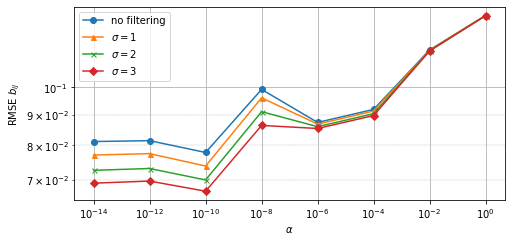

In [20]:
# create figure
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (7*ncols, 3.25*nrows), constrained_layout=True)

ax.loglog(lambdas, rmse_builtin, marker='o', markersize=6)
ax.loglog(lambdas, rmse_builtin_filt_1, marker='^', markersize=5) #, linestyle='-.')
ax.loglog(lambdas, rmse_builtin_filt_2, marker='x', markersize=5) #, linestyle='--')
ax.loglog(lambdas, rmse_builtin_filt_3, marker='D', markersize=5) #, linestyle=':')

# set minor ticks
ax.set_xticks(lambdas)
ax.legend([r'no filtering', r'$\sigma = 1$', r'$\sigma = 2$', r'$\sigma = 3$'])

# set grid
ax.grid(which='major')
ax.grid(which='minor', linestyle='--', linewidth=0.4)

# set labels
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'RMSE $b_{ij}$')

fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/numerical_results/network_parameters/'
fig_name = os.sep.join([fig_path, 'regularization_filtering.pdf'])
# plt.savefig(fig_name, format='pdf')